### A Single Trial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from multi_arm import Arm, monte_carlo_simulation, k_arm_bandit_mc, plot_history
import seaborn
# 5-arm figure: seed 6, 11
# 2-arm figure: seed 8

seed = 6
np.random.seed(seed)

In [2]:
ctrs = [0.04, 0.048, 0.03, 0.037, 0.044, 0.033, 0.02, 0.025, 0.028]
# ctrs = [0.04, 0.05]

true_winner_idx = np.argmax(ctrs)
print("true_winner_idx:", true_winner_idx, ctrs)

(winner_idx, est_ps, wins, traffic, history_ctr, history_p, history_idx, history_alphas, history_betas,
 values_remaining) = k_arm_bandit_mc(ctrs, alpha=0.05, burn_in=3000)

true_winner_idx: 1 [0.04, 0.048, 0.03, 0.037, 0.044, 0.033, 0.02, 0.025, 0.028]
Winning arm 1 beats second arm at iteration 52046


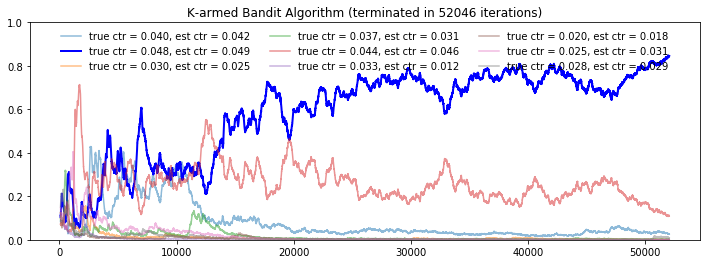

In [3]:
rolling=100 # this parameter does not affect the appearance of beta pdf
plot_history(ctrs, est_ps, history_p, 
             title="K-armed Bandit Algorithm (terminated in %i iterations)"%sum(traffic), rolling=rolling)

In [4]:
# turn winner's probability into data frame
cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]

data = {col : hist for col, hist in zip(cols, history_p)}
df_history_ma = pd.DataFrame(data).rolling(rolling).mean()

# turn click through ratre into data frame with same index, to be used as legend
data = {col : hist for col, hist in zip(cols, history_ctr)}
df_history_ctr = pd.DataFrame(data)

data = {col : hist for col, hist in zip(cols, history_alphas)}
df_history_alphas = pd.DataFrame(data)

data = {col : hist for col, hist in zip(cols, history_betas)}
df_history_betas = pd.DataFrame(data)

In [5]:
df_history_betas.head()

,arm_1_ctr=0.04,arm_2_ctr=0.05,arm_3_ctr=0.03,arm_4_ctr=0.04,arm_5_ctr=0.04,arm_6_ctr=0.03,arm_7_ctr=0.02,arm_8_ctr=0.03,arm_9_ctr=0.03
0,2,1,1,1,1,1,1,1,1
1,2,1,1,1,1,1,1,1,2
2,2,1,1,1,2,1,1,1,2
3,3,1,1,1,2,1,1,1,2
4,3,1,2,1,2,1,1,1,2


arm_1_ctr=0.04 180 4082
arm_2_ctr=0.05 1488 29083
arm_3_ctr=0.03 14 542
arm_4_ctr=0.04 29 915
arm_5_ctr=0.04 619 12847
arm_6_ctr=0.03 3 240
arm_7_ctr=0.02 6 328
arm_8_ctr=0.03 35 1109
arm_9_ctr=0.03 16 528
344.22841305608983


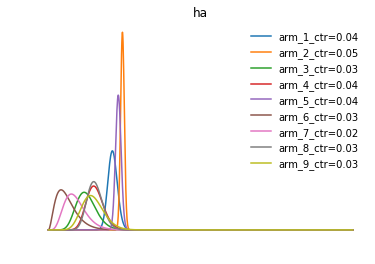

In [6]:
from scipy.stats import beta

plt.figure(frameon=False)
plt.axis('off')

x = np.linspace(0, 0.2, 1000)

idx = sum(traffic) - 1

alphas = df_history_alphas.loc[idx]
betas = df_history_betas.loc[idx]

y_max = 0
for col, a, b in zip(alphas.index.values, alphas, betas):
    print(col, a, b)
    rv = beta(a, b)
    y = rv.pdf(x)
    plt.plot(x, y, label=col)
    y_max = max(y_max, max(y))
plt.legend(frameon=False)
plt.title("ha")
y_max += 20
print(y_max)

### FuncAnimation
* 5 seconds, 48 frames per seconds

In [7]:
fps = 48
duration = 5

In [28]:
batch = int(sum(traffic) / (duration * fps))
print("batch", batch)
frames = []
for i in range(len(history_idx) // batch + 1):
    idx_end = min(len(history_idx) - 1, (i + 1) * batch)
    frames.append(idx_end)
    
# frames = frames[:30]

batch 68


(0, 182.03721431234365)

/Users/shawlu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


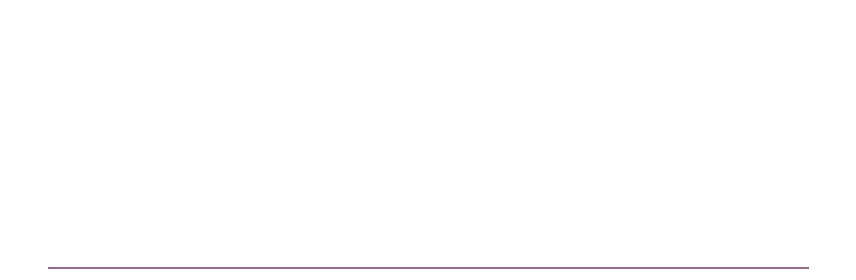

In [29]:
from matplotlib.animation import FuncAnimation
from scipy.stats import beta

x = np.linspace(0, 0.1, 1000)

color_dict = {}
lines = []
true_winner_idx = np.argmax(ctrs)
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
    
rv = beta(1, 1)

for i, col in enumerate(df_history_ma.columns):
    if i == true_winner_idx :
        line, = ax.plot(x, rv.pdf(x), lw=2, color='b')
    else:
        line, = ax.plot(x, rv.pdf(x), alpha=0.5)
    lines.append(line)
    color_dict[line] = line.get_color()

# minimalism style
ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# ax.grid()
# ax.set_xlabel('click_through_rate')
# ax.set_ylabel('PDF')
ax.set_ylim(0, y_max)

In [30]:
def update(i):
    print('iteration %i'%i, end="\r")
    est_ctrs = df_history_ctr.iloc[i].values
    winner_idx = np.argmax(est_ctrs)
    
    alphas = df_history_alphas.loc[i]
    betas = df_history_betas.loc[i]
    
    for idx, (col, a, b, line) in enumerate(zip(alphas.index.values, alphas, betas, lines)):
        rv = beta(a, b)
        line.set_ydata(rv.pdf(x))
        
        # highlight wrong arm in red, correct arm in blue
        # may appear messy if switching is frequent
#         if idx == true_winner_idx:
#             line.set_color('b')
#             line.set_lw(2)
#             line.set_alpha(1)
#         elif idx == winner_idx:
#             line.set_color('r')
#             line.set_lw(2)
#             line.set_alpha(1)
#         else:
#             line.set_color(color_dict[line])
#             line.set_lw(1)
#             line.set_alpha(0.5)

#     ax.set_title("%i-armed Bandit Experiment (%i iterations)"%(len(ctrs), i))
        
#     legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_ctrs)]
#     ax.legend(legend, frameon=False)

    return line, ax

anim = FuncAnimation(fig, update, frames=frames, interval=1000 / fps)

fname = 'animated_betas_%is_%ifps_seed%i.gif'%(duration, fps, seed)
anim.save(fname, dpi=80, writer='imagemagick')
print(fname)

plt.close()

animated_betas_5s_48fps_seed6.gif


In [8]:
fps = 48
duration = 5

In [9]:
batch = int(sum(traffic) / (duration * fps))
print("batch", batch)
frames = []
for i in range(len(history_idx) // batch + 1):
    idx_end = min(len(history_idx) - 1, (i + 1) * batch)
    frames.append(idx_end)
    
# frames = frames[:30]

batch 216


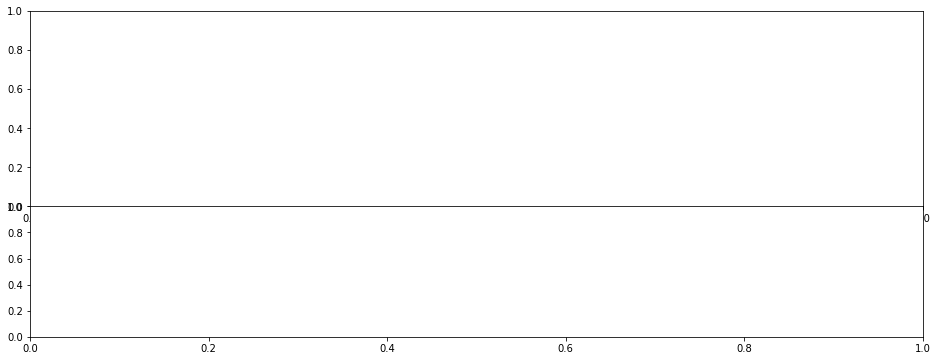

In [34]:
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(5, 11, hspace=0, wspace=0)

ax1 = fig.add_subplot(grid[:3, :])
ax2 = fig.add_subplot(grid[-2:, :])

344.22841305608983


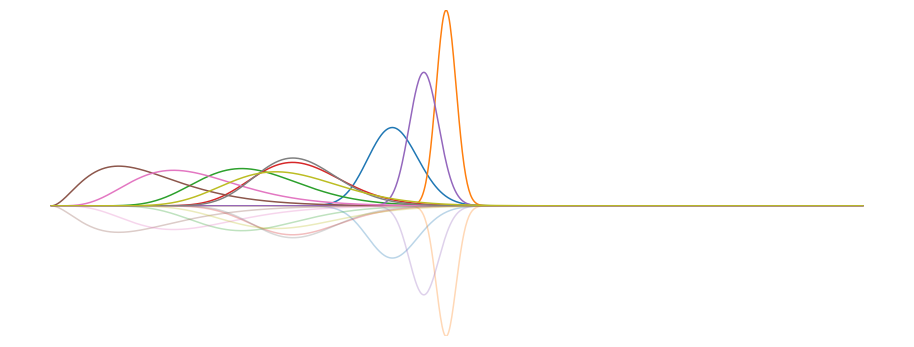

In [31]:
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(5, 11, hspace=0, wspace=0)

ax1 = fig.add_subplot(grid[:3, :])
ax2 = fig.add_subplot(grid[-2:, :])

# ax1 --------------------------------------
x = np.linspace(0, 0.1, 1000)
idx = sum(traffic) - 1
pdf1 = []

alphas = df_history_alphas.loc[idx]
betas = df_history_betas.loc[idx]

y_max = 0
for col, a, b in zip(alphas.index.values, alphas, betas):
    rv = beta(a, b)
    y = rv.pdf(x)
    pdf, = ax1.plot(x, y)
    pdf1.append(pdf)
    y_max = max(y_max, max(y))

# minimalism style
ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
# ax1.axis('off')
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.set_ylim(0, y_max)

# ax2
x = np.linspace(0, 0.1, 1000)
idx = sum(traffic) - 1
pdf2 = []

alphas = df_history_alphas.loc[idx]
betas = df_history_betas.loc[idx]

for col, a, b in zip(alphas.index.values, alphas, betas):
    rv = beta(a, b)
    y = rv.pdf(x)
    pdf, = ax2.plot(x, y, alpha=0.3)
    pdf2.append(pdf)

# minimalism style
ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
# ax1.axis('off')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.set_ylim(0, y_max)
ax2.invert_yaxis()

y_max += 20
print(y_max)

In [32]:
def update(i):
    print('iteration %i'%i, end="\r")
    
    alphas = df_history_alphas.loc[i]
    betas = df_history_betas.loc[i]
    
    for idx, (col, a, b, pdf1_, pdf2_) in enumerate(zip(alphas.index.values, alphas, betas, pdf1, pdf2)):
        rv = beta(a, b)
        pdf1_.set_ydata(rv.pdf(x))
        pdf2_.set_ydata(rv.pdf(x))

    return line, ax

anim = FuncAnimation(fig, update, frames=frames, interval=1000 / fps)

fname = 'animated_betas_art_%is_%ifps_seed%i.gif'%(duration, fps, seed)
anim.save(fname, dpi=80, writer='imagemagick')
print(fname)

plt.close()

animated_betas_art_5s_48fps_seed6.gif
